In [1]:
# Installing necessary dependent packages
!pip3 install -q ipython-autotime
!pip3 install -q matplotlib
!pip3 install -q seaborn

# Loading autotime for the notebook
%load_ext autotime

time: 610 µs (started: 2022-08-12 15:34:11 +00:00)


In [2]:
# Setting the environment variables

import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

time: 1.15 ms (started: 2022-08-12 15:34:11 +00:00)


# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number.

In [3]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

# PySpark SQL function and Types
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window as W

# Python Utilities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

time: 1.79 s (started: 2022-08-12 15:34:11 +00:00)


In [4]:
# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
spark

time: 4.14 s (started: 2022-08-12 15:34:13 +00:00)


In [5]:
# Spark session with 14 GB driver memory
spark.sparkContext.getConf().get('spark.driver.memory')

'14G'

time: 24.2 ms (started: 2022-08-12 15:34:17 +00:00)


In [6]:
# loading the dataset from the EC2 instance - 2019-Oct.csv

file_path = "../inputdata"
file_name = "2019-Oct.csv"

schema = T.StructType([T.StructField("event_time", T.StringType(), True),
                       T.StructField("event_type", T.StringType(), True),
                       T.StructField("product_id", T.IntegerType(), True),
                       T.StructField("category_id", T.StringType(), True),
                       T.StructField("category_code", T.StringType(), True),
                       T.StructField("brand", T.StringType(), True),
                       T.StructField("price", T.FloatType(), True),
                       T.StructField("user_id", T.IntegerType(), True),
                       T.StructField("user_session", T.StringType(), True)])

df = spark.read.format("csv").option("header", "true").schema(schema).load(f"{file_path}/{file_name}")

time: 1.97 s (started: 2022-08-12 15:34:17 +00:00)


In [7]:
DEBUG_MODE = False

if DEBUG_MODE:
    sample_fraction = 0.0025
    print(f"RUNNING IN DEBUG MODE with {sample_fraction * 100}% of the data")
    print(f"Original DataFrame count = {df.count()}")
    df = df.sample(withReplacement=False, fraction=sample_fraction, seed=42)
    print(f"Sampled DataFrame count = {df.count()}")
else:
    print("RUNNING IN NON-DEBUG MODE with full dataset")

RUNNING IN NON-DEBUG MODE with full dataset
time: 2.66 ms (started: 2022-08-12 15:34:19 +00:00)


In [8]:
# exploring the dataframe - top 20 rows
df.show(20)

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:...|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:...|      view|   1004237|205301355563188265

In [9]:
# exploring the dataframe - schema
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

time: 12.9 ms (started: 2022-08-12 15:34:22 +00:00)


In [10]:
# Number of rows and columns in the dataset
number_of_rows = df.count()
print(f'Number of Rows are: {number_of_rows}')
print(f'Number of Columns are: {len(df.columns)}')

Number of Rows are: 42448764
Number of Columns are: 9
time: 15.1 s (started: 2022-08-12 15:34:22 +00:00)


So, we have a huge dataset that contains 42 million rows.

Now, tha dataset is loaded in Spark environment. Let's proceed with the desired tasks.

<hr>

## Task 1 - Data Exploration

**Find**
- 5 most popular:
    - Products sold by the e-commerce company in the month
    - Brands on the platform
    - Product categories
- Number of unique users and the most active user on the platform
- Average and maximum price for smartphones purchased by the customers
<br>

**Plot and comment**
- Event-type funnel distribution in e-commerce shopping journey
- Traffic on different days of the week

Provide the results in a separate report.

In [11]:
# 5 most popular products sold
df.groupBy(F.col("product_id")).count().sort(F.desc("count")).show(5)

+----------+------+
|product_id| count|
+----------+------+
|   1004856|500354|
|   1004767|438232|
|   1005115|355786|
|   1004833|237545|
|   1004249|231070|
+----------+------+
only showing top 5 rows

time: 43 s (started: 2022-08-12 15:34:37 +00:00)


In [12]:
# 5 most popular brands
df.groupBy(F.col("brand")).count().sort(F.desc("count")).show(5)

+-------+-------+
|  brand|  count|
+-------+-------+
|   null|6113008|
|samsung|5282775|
|  apple|4122554|
| xiaomi|3083763|
| huawei|1111205|
+-------+-------+
only showing top 5 rows

time: 39.7 s (started: 2022-08-12 15:35:20 +00:00)


In [13]:
# Number of unique users
df.select(F.countDistinct("user_id")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                3022290|
+-----------------------+

time: 41.9 s (started: 2022-08-12 15:35:59 +00:00)


In [14]:
# The most active user on the platform
df.groupBy(F.col("user_id")).count().sort(F.desc("count")).show(5)

+---------+-----+
|  user_id|count|
+---------+-----+
|512475445| 7436|
|512365995| 4013|
|526731152| 2912|
|512505687| 2894|
|513021392| 2862|
+---------+-----+
only showing top 5 rows

time: 42 s (started: 2022-08-12 15:36:41 +00:00)


In [15]:
# Average and Maximum price for smartphones purchased by the customers
df.select(F.mean("price").alias("price_avg"), 
          F.max("price").alias("price_max")).show()

+-----------------+---------+
|        price_avg|price_max|
+-----------------+---------+
|290.3236605861753|  2574.07|
+-----------------+---------+

time: 34.8 s (started: 2022-08-12 15:37:23 +00:00)


In [16]:
df = df.withColumn("day_of_week", F.dayofweek(F.col("event_time")))
df.groupBy(F.col("day_of_week")).count().show()

+-----------+-------+
|day_of_week|  count|
+-----------+-------+
|          1|5855995|
|          6|5829660|
|          3|6801885|
|          5|6380367|
|          4|6652532|
|          7|5606796|
|          2|5321529|
+-----------+-------+

time: 45 s (started: 2022-08-12 15:37:58 +00:00)


In [17]:
# Event-type funnel distribution
# Remember Spark dataframe cannot be visualised directly
df_sampled = df.select(F.col("event_type")).sample(withReplacement=False, fraction=0.5, seed=42)
pandas_df_event_type = df_sampled.groupBy(F.col("event_type")).count().toPandas()

time: 36.6 s (started: 2022-08-12 15:38:43 +00:00)


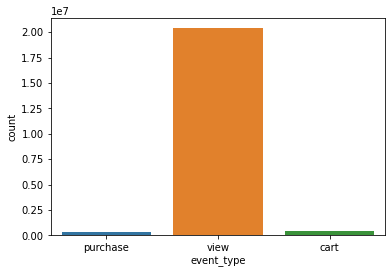

time: 255 ms (started: 2022-08-12 15:39:20 +00:00)


In [18]:
sns.barplot(x="event_type", y="count", data=pandas_df_event_type)
sns.set(rc={'figure.figsize': (15, 10)})
plt.show()

In [19]:
# Traffic on different days of the week
# Remember Spark dataframe cannot be visualised directly
df_sampled = df.select(F.col("day_of_week")).sample(withReplacement=False, fraction=0.5, seed=42)
df_day_of_week = df_sampled.groupBy(F.col("day_of_week")).count()
pandas_df_day_of_week = df_day_of_week.toPandas()

time: 42 s (started: 2022-08-12 15:39:20 +00:00)


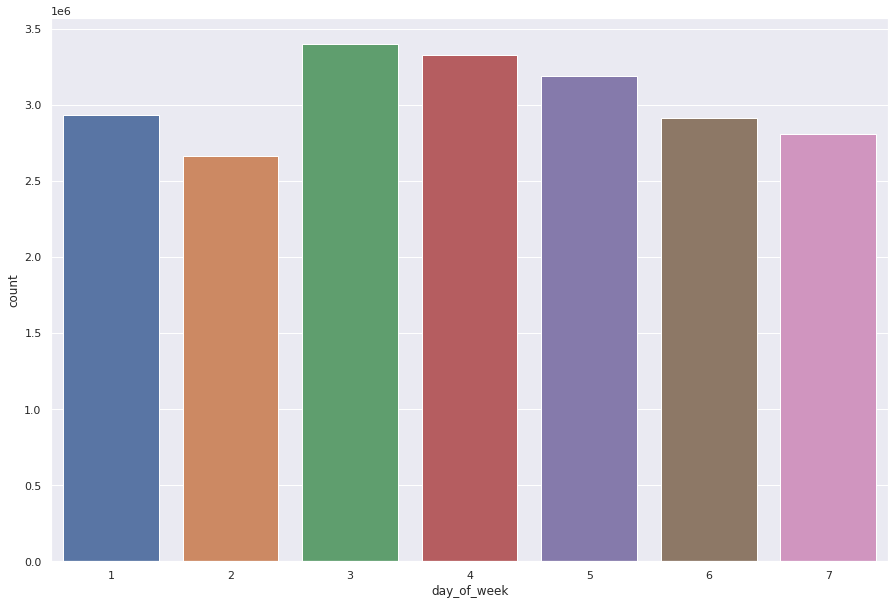

time: 312 ms (started: 2022-08-12 15:40:02 +00:00)


In [20]:
sns.barplot(x="day_of_week", y="count", data=pandas_df_day_of_week)
sns.set(rc={'figure.figsize': (15, 10)})
plt.show()

In [21]:
# drop redundant column(s), if any


time: 298 µs (started: 2022-08-12 15:40:02 +00:00)


<hr>

## Task 2 - Feature Engineering

- Handle missing values (provide justification for approach)
- Generate the category code at 2 levels (Split into 2 columns)
    - Example: electronics.video.tv - electronics, video
- Capture user activity in different columns
    - Total activities (view/cart/etc.) in the session
    - Affinity towards a particular product (Product count for user)
    - Affinity towards a category (Secondary category count for user)
    - Average shopping expense for a product category (secondary)
    - Number of user sessions
- Impact of time: Day and Hour (Binning hours into 4 buckets)
- Reduction in brands for analysis: Top 20 + ‘others’
- Target variable generation: is_purchased


In [22]:
# Handling missing values 
import functools
 
def unionAll(dfs):
    return functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)

df_missing_count = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns])
df_missing_percent = df.select([F.round((F.count(F.when(F.isnan(c) | 
                                                        F.col(c).isNull(), c))
                                         /F.count(F.lit(1)))*100, 4).alias(c) for c in df.columns])

df_missing = unionAll([df_missing_count, df_missing_percent])
df_missing.show()


+----------+----------+----------+-----------+-------------+---------+-----+-------+------------+-----------+
|event_time|event_type|product_id|category_id|category_code|    brand|price|user_id|user_session|day_of_week|
+----------+----------+----------+-----------+-------------+---------+-----+-------+------------+-----------+
|       0.0|       0.0|       0.0|        0.0|  1.3515609E7|6113008.0|  0.0|    0.0|         2.0|        0.0|
|       0.0|       0.0|       0.0|        0.0|      31.8398|  14.4009|  0.0|    0.0|         0.0|        0.0|
+----------+----------+----------+-----------+-------------+---------+-----+-------+------------+-----------+

time: 10min 16s (started: 2022-08-12 15:40:02 +00:00)


Reason for the action performed:



In [23]:
# Checking for duplicate entries
df_duplicates = df.groupBy(*df.columns).count().filter("count > 1")
df_duplicates = df_duplicates.drop('count')
number_of_rows_duplicates = df_duplicates.count()
print(f"Number of duplicate rows = {number_of_rows_duplicates}, i.e., " + 
      f"{(number_of_rows_duplicates/number_of_rows)*100:.4f}% of the dataset")

Number of duplicate rows = 18099, i.e., 0.0426% of the dataset
time: 2min 28s (started: 2022-08-12 15:50:19 +00:00)


In [24]:
# Take required action here
df = df.dropDuplicates()

time: 7.59 ms (started: 2022-08-12 15:52:47 +00:00)


In [25]:
# drop redundant column(s), if any


time: 271 µs (started: 2022-08-12 15:52:47 +00:00)


In [26]:
# Generating 2 columns from category code
# Columns have only single entity (electronics.video.tv: electronics, video)
# Check if split command works with '.' or Spark treats it as special character
split_category_code = F.split(F.col("category_code"), "[.]")
df = df.withColumn("category_code_primary", split_category_code.getItem(0)) \
        .withColumn("category_code_secondary", split_category_code.getItem(1)) \
            .withColumn("category_code_tertiary", split_category_code.getItem(2))

time: 88.9 ms (started: 2022-08-12 15:52:47 +00:00)


In [27]:
# Check if the column is added
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- category_code_primary: string (nullable = true)
 |-- category_code_secondary: string (nullable = true)
 |-- category_code_tertiary: string (nullable = true)

time: 1.65 ms (started: 2022-08-12 15:52:47 +00:00)


In [28]:
cols_to_remove = ["category_code"]
df = df.drop(*cols_to_remove)

time: 4.37 ms (started: 2022-08-12 15:52:47 +00:00)


In [29]:
# Activities in a session by the user
# Window functions can be helpful here
df = df.withColumn("total_activities_count", 
                   F.count("event_type").over(W.partitionBy([F.col("user_id"), F.col("user_session")]))
                   .cast(T.IntegerType()))

time: 120 ms (started: 2022-08-12 15:52:47 +00:00)


In [30]:
# View count for a product by the user
# Window functions can be helpful here
df = df.withColumn("user_product_count", 
                   F.count(F.col("event_type") == "view")
                   .over(W.partitionBy([F.col("user_id"), F.col("product_id")]))
                   .cast(T.IntegerType()))

time: 37.4 ms (started: 2022-08-12 15:52:47 +00:00)


In [31]:
# View count for the secondary category by the user
# Window functions can be helpful here
df = df.withColumn("category_secondary_count", 
                   F.count(F.col("event_type") == "view")
                   .over(W.partitionBy([F.col("user_id"), F.col("category_code_secondary")]))
                   .cast(T.IntegerType()))

time: 40.1 ms (started: 2022-08-12 15:52:47 +00:00)


In [32]:
# Average shopping expense for a product category
# Window functions can be helpful here
df = df.withColumn("average_price", 
                   F.avg(F.col("price"))
                   .over(W.partitionBy([F.col("category_code_primary"), 
                                        F.col("category_code_secondary")]))
                   .cast(T.DecimalType(scale=4)))

time: 42.5 ms (started: 2022-08-12 15:52:47 +00:00)


In [33]:
# Session count for a user
# Window functions can be helpful here
df = df.withColumn("session_count", 
                   F.count("user_session").over(W.partitionBy("user_id"))
                   .cast(T.IntegerType()))

time: 28.2 ms (started: 2022-08-12 15:52:47 +00:00)


In [34]:
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- category_code_primary: string (nullable = true)
 |-- category_code_secondary: string (nullable = true)
 |-- category_code_tertiary: string (nullable = true)
 |-- total_activities_count: integer (nullable = false)
 |-- user_product_count: integer (nullable = false)
 |-- category_secondary_count: integer (nullable = false)
 |-- average_price: decimal(10,4) (nullable = true)
 |-- session_count: integer (nullable = false)

time: 2.44 ms (started: 2022-08-12 15:52:47 +00:00)


In [35]:
# Generating the hour variable
df = df.withColumn('hour', F.hour(F.to_timestamp(F.col("event_time"), 'yyyy-MM-dd HH:mm:ss')))

time: 18.4 ms (started: 2022-08-12 15:52:47 +00:00)


In [36]:
# Reduction in brands for analysis: Top 20 + ‘others'
df = df.withColumn("brand", F.when(F.col("brand").isNull(), "others").otherwise(F.col("brand")))
df_top_brands = df.groupBy(F.col("brand")).count().sort(F.desc("count")).select(F.col("brand")).limit(21)
top_brands = df_top_brands.toPandas().values.reshape(-1).tolist()

time: 2min 26s (started: 2022-08-12 15:52:47 +00:00)


In [37]:
df = df.withColumn("brand", F.when(F.col("brand").isin(top_brands[1:]), F.col("brand"))
                            .otherwise("others"))

time: 140 ms (started: 2022-08-12 15:55:14 +00:00)


In [38]:
df.groupBy('brand').count().show()

+--------+--------+
|   brand|   count|
+--------+--------+
| philips|  282504|
|cordiant|  368045|
|   apple| 4116981|
|   casio|  257987|
|    oppo|  482131|
| redmond|  279620|
|  others|22678765|
|      lg|  561883|
|    sony|  456429|
|    acer|  427882|
|   artel|  337966|
| samsung| 5271172|
| respect|  271164|
| lucente|  655818|
|  huawei| 1109758|
|  lenovo|  337987|
|      hp|  305133|
|   bosch|  556877|
|dauscher|  289734|
|  xiaomi| 3080998|
+--------+--------+
only showing top 20 rows

time: 2min 46s (started: 2022-08-12 15:55:15 +00:00)


In [39]:
# Generating 'is_purchased' variable


time: 314 µs (started: 2022-08-12 15:58:01 +00:00)


In [40]:
# Dropping redundant rows
# cols_to_remove = []
# df = df.drop(*cols_to_remove)

time: 1.16 ms (started: 2022-08-12 15:58:01 +00:00)


In [41]:
# Printing the top 20 rows as output
df.show(20, truncate=False)

+-----------------------+----------+----------+-------------------+------+------+---------+------------------------------------+-----------+---------------------+-----------------------+----------------------+----------------------+------------------+------------------------+-------------+-------------+----+
|event_time             |event_type|product_id|category_id        |brand |price |user_id  |user_session                        |day_of_week|category_code_primary|category_code_secondary|category_code_tertiary|total_activities_count|user_product_count|category_secondary_count|average_price|session_count|hour|
+-----------------------+----------+----------+-------------------+------+------+---------+------------------------------------+-----------+---------------------+-----------------------+----------------------+----------------------+------------------+------------------------+-------------+-------------+----+
|2019-10-05 12:34:23 UTC|view      |18500054  |2053013552695869677|oth

In [42]:
# Dropping the redundant columns 
cols_to_remove = ["event_time", "event_type", "user_session"]
df = df.drop(*cols_to_remove)

time: 187 ms (started: 2022-08-12 16:07:00 +00:00)


In [43]:
# Columns in df after feature engineering
df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- category_code_primary: string (nullable = true)
 |-- category_code_secondary: string (nullable = true)
 |-- category_code_tertiary: string (nullable = true)
 |-- total_activities_count: integer (nullable = false)
 |-- user_product_count: integer (nullable = false)
 |-- category_secondary_count: integer (nullable = false)
 |-- average_price: decimal(10,4) (nullable = true)
 |-- session_count: integer (nullable = false)
 |-- hour: integer (nullable = true)

time: 1.12 s (started: 2022-08-12 16:07:01 +00:00)


In [45]:
# Storing the cleaned df in the instance to prevent repetition of steps again
# Rename the file based on your preferences
if DEBUG_MODE:
    print("SAVING CLEANED DF IN DEBUG MODE")
    df.coalesce(1).write.option("header", "true").parquet("cleaned_df_sampled.parquet")
else:
    print("SAVING CLEANED DF IN NON-DEBUG MODE")
    df.coalesce(1).write.option("header", "true").parquet("cleaned_df.parquet")

SAVING CLEANED DF IN NON-DEBUG MODE
time: 11min 54s (started: 2022-08-12 16:07:34 +00:00)


Proceed to another notebooks after saving the dataframe.